# Problem Statement

Kickstarter is a popular crowdfunding platform. In the exploratory analysis previously done the factors affecting the success of a crowdfunding campaign. Here the goal is to predict if a kickstarter project will be successful or will fail before its actual deadline.

In [ ]:
#Setting up required libraries and packages

In [100]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn import preprocessing
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.tools as tls
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings
from collections import Counter

# Data Overview

There are a combined data of 700,000+ projects from two data sources.
Below is the brief summary of the explanatory variables

ID                :  It is the unique identifier for a project.

Name              :  Name of the project seeking crowdfunding.

Category          :  Category in which the project falls

Main Category     :  The high level category on which the project falls

Currency          :  Self - Explanatory.

Deadline          :  The date by which the project tends to seek crowdfunding for the campaign. 

Goal              :  Amount the crowdfunding campaign seeks for itself.

Launched          :  The date on which the project is launched.

Pledged           :  The amount that was pledged by the backers of the campaign.

State             :  The final state, determining whether the project was successful, unsuccessful, cancelled or failed.

Backers           :  The count of the number of users backing the project.

Country           :  The country of origination

USD Pledged       :  The amount in US Dollor pledged for the project.

In [59]:
# Importing Data
df_kick_201801 = pd.read_csv("ks-projects-201801.csv",encoding = "utf-8",low_memory=False)
df_kick_201612 = pd.read_csv("ks-projects-201612.csv",encoding = "utf-8",low_memory=False)

Checking the structure of the of the two datasets

In [16]:
print(df_kick_201801.shape)
print(df_kick_201612.shape)

(378661, 15)
(323750, 17)


Checking the relevant columns and merge the two datasets,
df_kick_main is the main workset for the analysis

In [103]:
#df_kick_201612_Workset=df_kick_201612.iloc[:,0:12]
df_kick_main=df_kick_201801.iloc[:,0:12]
#df_kick_main = df_kick_201612_Workset.append(df_kick_201801_Workset)

Aggregated Dataset

In [104]:
df_kick_main.shape
df_kick_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 12 columns):
ID               378661 non-null int64
name             378657 non-null object
category         378661 non-null object
main_category    378661 non-null object
currency         378661 non-null object
deadline         378661 non-null object
goal             378661 non-null float64
launched         378661 non-null object
pledged          378661 non-null float64
state            378661 non-null object
backers          378661 non-null int64
country          378661 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 34.7+ MB


Segregating the variables as categorical and constinuous

In [72]:
df_kick_main.columns = ['ID','name','category','main_category','currency','deadline','goal','launched','pledged','state','backers','country']

ks_cat_vars=[ 'category', 'main_category', 'currency','country']
ks_cont_vars=['goal', 'pledged', 'backers','pledged']

Checking correlation among the continous variables defined above. It can be seen that pledged (USD amount) and backers have high correlation > 0.75. It is expected behavior as more backers would mean more amount pledged.


In [91]:
df_kick_main[ks_cont_vars]

""


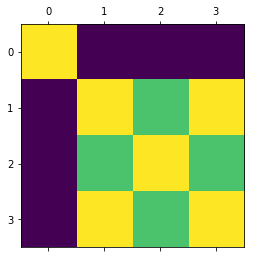

In [105]:
import matplotlib.pyplot as plt

plt.matshow(df_kick_main[ks_cont_vars].corr())

Filtering only for successful and failed projects for subsequent EDA

In [106]:
kick_projects = df_kick_main[(df_kick_main['state'] == 'failed') | (df_kick_main['state'] == 'successful')]
#converting 'successful' state to 1 and failed to 0
kick_projects['state'] = (kick_projects['state'] =='successful').astype(int)
print(kick_projects.shape)

(331675, 12)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [107]:
#checking distribution of projects across various main categories
kick_projects.groupby(['main_category','state']).size()
#kick_projects.groupby(['category','state']).size()

main_category  state
Art            0        14131
               1        11510
Comics         0         4036
               1         5842
Crafts         0         5703
               1         2115
Dance          0         1235
               1         2338
Design         0        14814
               1        10550
Fashion        0        14182
               1         5593
Film & Video   0        32904
               1        23623
Food           0        15969
               1         6085
Games          0        16003
               1        12518
Journalism     0         3137
               1         1012
Music          0        21752
               1        24197
Photography    0         6384
               1         3305
Publishing     0        23145
               1        12300
Technology     0        20616
               1         6434
Theater        0         3708
               1         6534
dtype: int64

To visualise the distribution of the original states, the original dataset is used 'df_kick_main' is used.
To make more sense of the state distributions the percentages of the states are visualised.

In [108]:
percentual_sucess = round(df_kick_main["state"].value_counts() / len(df_kick_main["state"]) * 100,2)

print("State Percentual in %: ")
print(percentual_sucess)

state = round(df_kick_main["state"].value_counts() / len(df_kick_main["state"]) * 100,2)

labels = list(state.index)
values = list(state.values)

trace1 = go.Pie(labels=labels, values=values, marker=dict(colors=['red']))

layout = go.Layout(title='Distribuition of States', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

State Percentual in %: 
failed        52.22
successful    35.38
canceled      10.24
undefined      0.94
live           0.74
suspended      0.49
Name: state, dtype: float64


In the subsequent three plots (in a defined gridline)
The log scaled goal and pledged amount is plotted for both failed and sucessful projects

In [124]:
df_failed = df_kick_main[df_kick_main["state"] == "failed"]
df_sucess = df_kick_main[df_kick_main["state"] == "successful"]

#First plot
trace0 = go.Histogram(
    x= np.log(df_kick_main.goal + 1),
    histnorm='probability', showlegend=False,
    xbins=dict(
        start=-5.0,
        end=19.0,
        size=1),
    autobiny=True)

#Second plot
trace1 = go.Histogram(
    x = np.log(df_kick_main.pledged + 1),
    histnorm='probability', showlegend=False,
    xbins=dict(
        start=-1.0,
        end=17.0,
        size=1))

# Add histogram data
x1 = np.log(df_failed['goal']+1)
x2 = np.log(df_sucess["goal"]+1)

trace3 = go.Histogram(
    x=x1,
    opacity=0.60, nbinsx=30, name='Goals Failed', histnorm='probability'
)
trace4 = go.Histogram(
    x=x2,
    opacity=0.60, nbinsx=30, name='Goals Sucessful', histnorm='probability'
)


data = [trace0, trace1, trace3, trace4]
layout = go.Layout(barmode='overlay')

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[ [{'colspan': 2}, None], [{}, {}]],
                          subplot_titles=('Failed and Sucessful Projects',
                                          'Goal','Pledged'))

#setting the figs
fig.append_trace(trace0, 2, 1)
fig.append_trace(trace1, 2, 2)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)

#fig['layout'].update(title="Distribuitions",
 #                    height=500, width=900, barmode='overlay')
#iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1           -      ]
[ (2,1) x2,y2 ]  [ (2,2) x3,y3 ]



#Feature Engineering

The  below code snippet does the following:

Part 1 : Extraction of components like year, month, hour from launch date.
Part 2 : Extraction of components like year, month, time to deadline from deadline date.
Part 3 : Calculating project duration

In [120]:
df_kick_main['launched'] = pd.to_datetime(df_kick_main['launched'])
df_kick_main['laun_month_year'] = df_kick_main['launched'].dt.to_period("M")
df_kick_main['laun_year'] = df_kick_main['launched'].dt.to_period("A")
df_kick_main['laun_hour'] = df_kick_main['launched'].dt.hour

df_kick_main['deadline'] = pd.to_datetime(df_kick_main['deadline'])
df_kick_main['dead_month_year'] = df_kick_main['deadline'].dt.to_period("M")
df_kick_main['dead_year'] = df_kick_main['launched'].dt.to_period("A")


#Creating a new columns with Campaign total months
df_kick_main['time_campaign'] = df_kick_main['dead_month_year'] - df_kick_main['laun_month_year']
df_kick_main['time_campaign'] = df_kick_main['time_campaign'].astype(int)

The crucial piece of visualisation is how project duration affects the state of the project.
The duration is calulated as time campaign above.

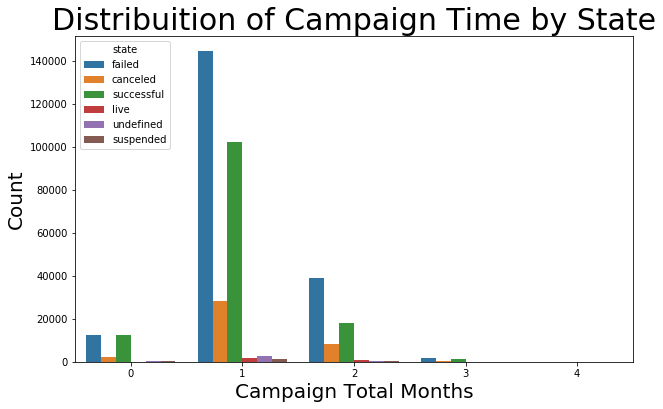

Descriptions of Campaign Time x State
state          canceled  failed  live  successful  suspended  undefined
time_campaign                                                          
0                  2044   12276    62       12494        153        280
1                 28144  144494  1785      102102       1251       2710
2                  8132   38960   948       18240        433        570
3                   453    1976     4        1117          8          2
4                     0      13     0           3          0          0


In [121]:
plt.figure(figsize = (10,6))

ax = sns.countplot(x='time_campaign', hue='state', 
                   data=df_kick_main[df_kick_main['time_campaign'] < 10])
ax.set_title("Distribuition of Campaign Time by State", fontsize=30)
ax.set_xlabel("Campaign Total Months", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.show()

print("Descriptions of Campaign Time x State")
print(pd.crosstab(df_kick_main[df_kick_main['time_campaign'] < 5]['time_campaign'], df_kick_main.state))